## Rover Lab Notebook
This notebook contains the functions from the lesson and provides the scaffolding you need to test out your mapping methods.  The steps you need to complete in this notebook for the project are the following:

* First just run each of the cells in the notebook, examine the code and the results of each.

**Note: For the online lab, data has been collected and provided for you. If you would like to try locally please do so! Please continue instructions from the continue point.**
* Run the simulator in "Training Mode" and record some data. Note: the simulator may crash if you try to record a large (longer than a few minutes) dataset, but you don't need a ton of data, just some example images to work with.   
* Change the data directory path (2 cells below) to be the directory where you saved data
* Test out the functions provided on your data

**Continue Point**
* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Once you have mapping working, move on to modifying `perception.py` and `decision.py` in the project to allow your rover to navigate and map in autonomous mode!

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

**Run the next cell to get code highlighting in the markdown cells.**

In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [2]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder

## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

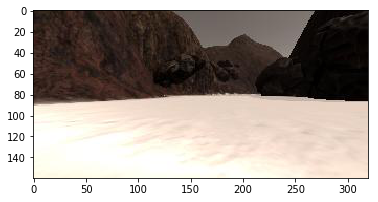

In [3]:
path = './test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

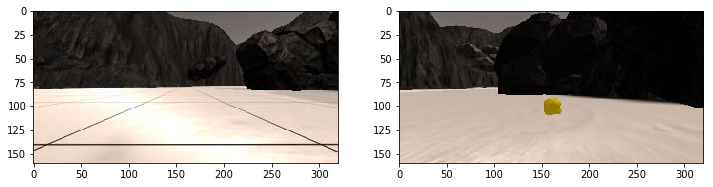

In [4]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = './calibration_images/example_grid1.jpg'
example_rock = './calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

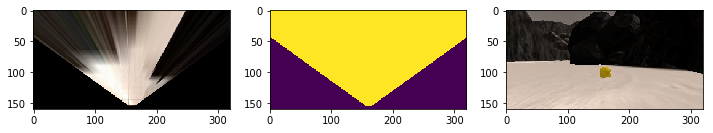

In [45]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    mask = cv2.warpPerspective(np.ones_like(img[:,:,0]), M, (img.shape[1], img.shape[0]))
    
    return warped, mask


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped, mask = perspect_transform(grid_img, source, destination)

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(warped)
plt.subplot(132)
plt.imshow(mask)
plt.subplot(133)
plt.imshow(rock_img)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

**TODO:** Ultimately, you want your map to not just include navigable terrain but also obstacles and the positions of the rock samples you're searching for.  Modify this function or write a new function that returns the pixel locations of obstacles (areas below the threshold) and rock samples (yellow rocks in calibration images), such that you can map these areas into world coordinates as well.  
**Suggestion:** Think about imposing a lower and upper boundary in your color selection to be more specific about choosing colors.  Feel free to get creative and even bring in functions from other libraries.  Here's an example of [color selection](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) using OpenCV.  
**Beware:** if you start manipulating images with OpenCV, keep in mind that it defaults to `BGR` instead of `RGB` color space when reading/writing images, so things can get confusing.

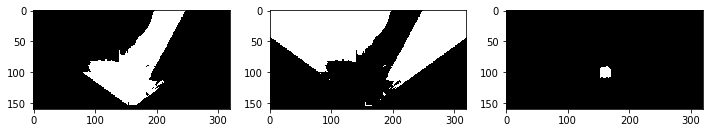

In [46]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh_bellow=(160, 160, 160), rgb_thresh_up=(255, 255, 255)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh_bellow[0]) \
                & (img[:,:,0] < rgb_thresh_up[0] + 1) \
                & (img[:,:,1] > rgb_thresh_bellow[1]) \
                & (img[:,:,1] < rgb_thresh_up[1] + 1) \
                & (img[:,:,2] > rgb_thresh_bellow[2]) \
                & (img[:,:,2] < rgb_thresh_up[1] + 1)
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

def find_rocks(img):
    hsv_rock = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # define range of yellow color in HSV
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([100, 255, 255])

    rock = cv2.inRange(hsv_rock, lower_yellow, upper_yellow)

    return rock

threshed = color_thresh(warped)
threshed_obs = mask - threshed

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(threshed, cmap='gray')
plt.subplot(132)
plt.imshow(threshed_obs, cmap = 'gray')
plt.subplot(133)
plt.imshow(find_rocks(rock_img), cmap = 'gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

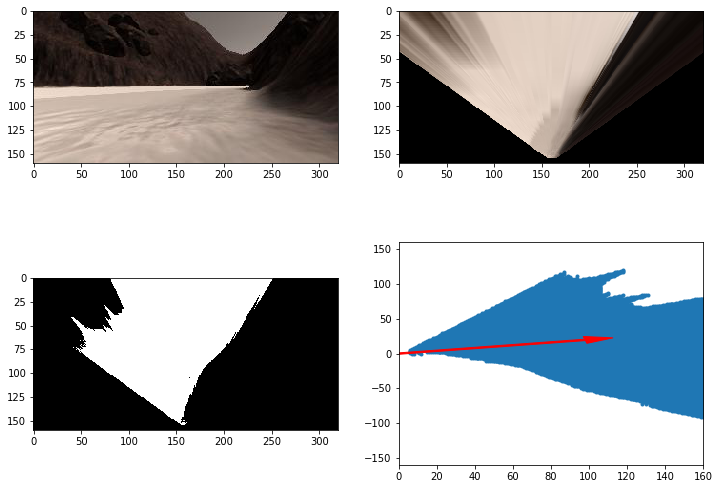

In [49]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[0]).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    # TODO:
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    # Apply a rotation
    xpix_rotated = xpix * np.cos(yaw_rad) - ypix * np.sin(yaw_rad)
    ypix_rotated = xpix * np.sin(yaw_rad) + ypix * np.cos(yaw_rad)
    # Return the result  
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # TODO:
    # Apply a scaling and a translation
    # Assume a scale factor of 10 between world space pixels and rover space pixels
    scale = 10
    # Perform translation and convert to integer since pixel values can't be float
    xpix_translated = np.int_(xpos + (xpix_rot / scale))
    ypix_translated = np.int_(ypos + (ypix_rot / scale))
    # Return the result  
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped, mask = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)



## Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.  


In [50]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change this path to your data directory
df = pd.read_csv('./test_dataset/robot_log.csv')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('./calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = -1 # This will be a running index, setting to -1 is a hack
                        # because moviepy (below) seems to run one extra iteration
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


## Write a function to process stored images

Modify the `process_image()` function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the images you saved taking data in the simulator.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  



To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process.  Feel free to get creative!

In [61]:

# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # TODO: 
    # 1) Define source and destination points for perspective transform
    # Define calibration box in source (actual) and destination (desired) coordinates
    # These source and destination points are defined to warp the image
    # to a grid where each 10x10 pixel square represents 1 square meter
    # The destination box will be 2*dst_size on each side
    dst_size = 5 
    # Set a bottom offset to account for the fact that the bottom of the image 
    # is not the position of the rover but a bit in front of it
    # this is just a rough guess, feel free to change it!
    bottom_offset = 6
    source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    destination = np.float32([[img.shape[1]/2 - dst_size, img.shape[0] - bottom_offset],
                      [img.shape[1]/2 + dst_size, img.shape[0] - bottom_offset],
                      [img.shape[1]/2 + dst_size, img.shape[0] - 2*dst_size - bottom_offset], 
                      [img.shape[1]/2 - dst_size, img.shape[0] - 2*dst_size - bottom_offset],
                      ])
    # 2) Apply perspective transform
    warped, mask = perspect_transform(img, source, destination)
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    threshed = color_thresh(warped)
    obs = mask - threshed
    rock = find_rocks(img)
    
    # 4) Convert thresholded image pixel values to rover-centric coords
    xpix, ypix = rover_coords(threshed)
    xpix_obs, ypix_obs = rover_coords(obs)
    # 5) Convert rover-centric pixel values to world coords
    scale = 10
    x_world, y_world = pix_to_world(xpix, ypix, data.xpos[data.count], 
                                data.ypos[data.count], data.yaw[data.count], 
                                data.worldmap.shape[0], scale)
    
    x_world_obs, y_world_obs = pix_to_world(xpix_obs, ypix_obs, data.xpos[data.count], 
                                data.ypos[data.count], data.yaw[data.count], 
                                data.worldmap.shape[0], scale)
    # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1
    data.worldmap[y_world_obs, x_world_obs, 0] = 255
    if rock.any():
        xpix_rock, ypix_rock = rover_coords(rock)
        x_world_rock, y_world_rock = pix_to_world(xpix_rock, ypix_rock, data.xpos[data.count], 
                                    data.ypos[data.count], data.yaw[data.count], 
                                    data.worldmap.shape[0], scale)
        data.worldmap[y_world_rock, x_world_rock, 1] = 255

    data.worldmap[y_world, x_world, 2] = 255

    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
    warped, mask = perspect_transform(img, source, destination)
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

## Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

In [62]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = './output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

132.2827 104.8689 36.71686
[MoviePy] >>>> Building video ./output/test_mapping.mp4
[MoviePy] Writing video ./output/test_mapping.mp4


  2%|▏         | 6/283 [00:00<00:04, 57.64it/s]

99.66999 85.58897 56.82555
99.66999 85.58897 56.82555
99.66999 85.58897 56.82555
99.66999 85.58897 56.82555
99.66999 85.58897 56.82555
99.66999 85.58897 56.82555
99.66999 85.58897 56.82555
99.66999 85.58897 56.82555
99.66999 85.58897 56.82555
99.67065 85.58999 56.82557
99.67067 85.59003 56.82542
99.67067 85.59003 56.82542


  6%|▋         | 18/283 [00:00<00:04, 56.07it/s]

99.67066 85.59003 56.82542
99.67066 85.59003 56.82542
99.67065 85.59003 56.82542
99.67065 85.59003 56.82541
99.67064 85.59003 56.82541
99.67064 85.59003 56.82541
99.67063 85.59003 56.82541
99.67062 85.59003 56.82541
99.67062 85.59003 56.82541
99.67062 85.59004 56.8254
99.67062 85.59005 56.8254


 10%|█         | 29/283 [00:00<00:04, 54.20it/s]

99.67062 85.59005 56.8254
99.6708 85.59032 56.82637
99.67083 85.59038 56.81548
99.67176 85.5918 56.8225
99.67332 85.59421 56.71502
99.67529 85.59719 56.69259
99.67777 85.60096 56.73291
99.68341 85.6096 56.87181
99.68764 85.61605 56.75683
99.69625 85.62922 56.75086
99.70283 85.63936 56.88911
99.71024 85.65078 56.9262


 14%|█▍        | 41/283 [00:00<00:04, 54.72it/s]

99.71787 85.66252 56.97526
99.72574 85.67455 57.01448
99.73707 85.69167 56.98602
99.74576 85.70506 56.93539
99.76088 85.72845 56.8792
99.77776 85.75455 56.88481
99.797 85.78428 56.86582
99.81023 85.8047 56.83552
99.83139 85.83752 56.96938


 17%|█▋        | 47/283 [00:00<00:05, 44.51it/s]

99.84605 85.86028 57.06387
99.86151 85.88438 57.10579
99.87763 85.90944 57.08944
99.90364 85.94996 57.10592
99.92182 85.9783 57.13094
99.95082 86.02351 57.15678
99.97074 86.05458 57.21354


 18%|█▊        | 52/283 [00:01<00:05, 42.72it/s]

99.99143 86.08694 57.22939
100.0236 86.13731 57.23721


 20%|██        | 57/283 [00:01<00:05, 42.84it/s]

100.0459 86.17214 57.2653
100.0807 86.22678 57.22249
100.1048 86.26463 57.22782
100.1422 86.32312 57.25601
100.1679 86.36343 57.27493
100.2078 86.42599 57.31474
100.2352 86.469 57.33373


 22%|██▏       | 62/283 [00:01<00:05, 43.36it/s]

100.2775 86.53555 57.35979
100.3065 86.58121 57.36985


 24%|██▎       | 67/283 [00:01<00:04, 44.68it/s]

100.3362 86.62803 57.3862
100.382 86.7002 57.40292
100.4134 86.7497 57.41326
100.4454 86.80023 57.42235
100.4947 86.87801 57.43327
100.5284 86.93118 57.44131
100.5801 87.0129 57.45065
100.6154 87.06869 57.4585
100.6696 87.15439 57.46998
100.7065 87.21281 57.47704


 27%|██▋       | 77/283 [00:01<00:05, 40.62it/s]

100.7441 87.27225 57.48423
100.8016 87.36334 57.49623
100.8408 87.42538 57.5027
100.9008 87.52039 57.5137
100.9416 87.58498 57.52087
100.983 87.65063 57.52985
101.0463 87.75102 57.54066
101.0892 87.81926 57.5657


 29%|██▉       | 82/283 [00:01<00:05, 38.88it/s]

101.1536 87.92416 57.83541
101.1962 87.99583 58.20792
101.2594 88.10626 59.00399
101.3006 88.18201 59.70157
101.3412 88.25932 60.47002


 30%|███       | 86/283 [00:01<00:05, 38.75it/s]

101.4032 88.37705 61.36253
101.4455 88.45683 61.73438
101.4889 88.53773 61.90596


 32%|███▏      | 90/283 [00:02<00:05, 38.21it/s]

101.5549 88.66154 61.97487
101.5995 88.74553 61.98918
101.6669 88.87303 62.00551
101.7122 88.95907 62.01611
101.7581 89.0461 62.02626


 33%|███▎      | 94/283 [00:02<00:04, 37.86it/s]

101.8279 89.17898 62.0603
101.8742 89.26921 62.24748
101.92 89.36086 62.61549


 35%|███▍      | 98/283 [00:02<00:04, 37.61it/s]

101.9889 89.50081 63.19849
102.0354 89.59543 63.45715
102.1059 89.7394 63.72102
102.1525 89.83711 64.00562
102.1983 89.93626 64.45742


 36%|███▌      | 102/283 [00:02<00:04, 38.30it/s]

102.2668 90.0874 65.16776
102.3126 90.1897 65.52991
102.3819 90.34528 65.91586
102.4286 

 37%|███▋      | 106/283 [00:02<00:04, 37.91it/s]

90.45034 66.03239
102.4752 90.55662 66.20061
102.5432 90.71885 66.8178
102.5876 90.82874 67.36688
102.6548 90.99569 67.95786


 39%|███▉      | 110/283 [00:02<00:04, 37.23it/s]

102.6999 91.10857 68.22184
102.766 91.28044 68.80522
102.8079 91.39691 69.4617


 40%|████      | 114/283 [00:02<00:04, 36.76it/s]

102.8484 91.51441 70.25198
102.907 91.69287 71.47055
102.9441 91.81377 72.28816
102.9981 91.99757 73.38407
103.0315 92.12179 74.25146


 42%|████▏     | 118/283 [00:02<00:04, 36.05it/s]

103.0779 92.3102 75.75044
103.1073 92.43719 76.63359
103.1502 92.63037 77.56241


 43%|████▎     | 122/283 [00:02<00:04, 36.33it/s]

103.1788 92.76096 77.88167
103.2078 92.89313 78.01364
103.2514 93.09423 78.07328
103.2809 93.23 78.0602


 45%|████▍     | 126/283 [00:03<00:04, 34.29it/s]

103.3109 93.3671 78.00909
103.3565 93.57526 77.91139
103.3872 93.71567 77.87611


 46%|████▌     | 130/283 [00:03<00:04, 34.35it/s]

103.4181 93.85728 77.85344
103.465 94.07202 77.82884
103.4968 94.21663 77.79743
103.5464 94.43549 77.56207
103.5813 94.58248 77.24284
103.6179 94.7302 76.78392
103.6753 94.95196 75.7267


 47%|████▋     | 134/283 [00:03<00:04, 33.35it/s]

103.7159 95.09849 74.72603
103.7826 95.31466 72.68961
103.8311 95.45625 71.1333
103.8835 95.59643 69.47205


 49%|████▉     | 138/283 [00:03<00:04, 32.07it/s]

103.9723 95.80537 67.06825
104.0359 95.94311 65.52442
104.1021

 50%|█████     | 142/283 [00:03<00:04, 30.65it/s]

 96.0809 64.05154
104.2066 96.28983 62.06594
104.2803 96.42988 60.78008
104.4 96.63942 58.65003
104.4846 96.7762 57.1133
104.574 96.90939 55.41125


 53%|█████▎    | 149/283 [00:03<00:04, 28.76it/s]

104.718 97.10326 52.96165
104.8186 97.23083 51.45167
104.9224 97.35765 50.0022
105.0851 97.54298 47.7893
105.1978 97.6636 46.28237
105.3751 97.83971 44.04572


 55%|█████▍    | 155/283 [00:04<00:04, 28.55it/s]

105.4971 97.95413 42.55407
105.6225 98.06591 41.06266
105.7513 98.17452 39.58194
105.9511 98.33268 37.37595
106.0881 98.43437 35.89704
106.2282 98.53297 34.41616


 57%|█████▋    | 161/283 [00:04<00:04, 26.20it/s]

106.4444 98.67451 32.21879
106.592 98.76511 30.74901
106.7424 98.85236 29.26661
106.9736 98.9761 27.0724
107.1309 99.05443 25.60793
107.2907 

 58%|█████▊    | 164/283 [00:04<00:04, 25.77it/s]

99.12914 24.13171
107.453 99.19995 22.65807
107.7011 99.29843 20.4811
107.8691 99.35992 19.04388
108.039

 59%|█████▉    | 168/283 [00:04<00:04, 26.97it/s]

 99.41705 17.58406
108.2115 99.47005 16.13737


 60%|██████    | 171/283 [00:04<00:04, 27.12it/s]

108.4734 99.54164 13.96394
108.6505 99.58437 12.54346
108.8291 99.62322 11.10295
109.1 99.67268 8.941551


 61%|██████▏   | 174/283 [00:04<00:04, 26.40it/s]

109.2824 99.70014 7.503281
109.4658 99.72329 6.06736


 63%|██████▎   | 177/283 [00:04<00:04, 25.60it/s]

109.6512 99.7411 4.633476
109.8367 99.7557 3.278915
110.1172 99.77056 1.210754
110.305 99.773 359.7514


 64%|██████▎   | 180/283 [00:05<00:04, 25.59it/s]

110.4939 99.77106 358.3399


 65%|██████▍   | 183/283 [00:05<00:03, 25.86it/s]

110.7779 99.76072 356.2529
110.9682 99.7477 354.8669
111.1586 99.73002 353.4712
111.4444 99.69476 351.377


 66%|██████▌   | 186/283 [00:05<00:03, 24.73it/s]

111.6347 99.66462 349.9948
111.9206 99.61458 348.0704


 67%|██████▋   | 189/283 [00:05<00:03, 24.45it/s]

112.1109 99.57439 346.7065
112.3008 99.52912 345.4606
112.5858 99.45514 343.9397
112.776 99.40215 343.1592
112.9664 99.34651 342.5939
113.1575 99.28871 342.2404


 69%|██████▉   | 195/283 [00:05<00:03, 26.07it/s]

113.4448 99.19936 341.9935
113.6363 99.13851 341.921
113.828 99.07708 341.8993
114.02 99.01573 341.9667
114.3093 98.92374 342.1723
114.5023 98.86247 342.2795


 71%|███████   | 201/283 [00:05<00:03, 25.71it/s]

114.7918 98.77076 342.3696
114.9853 98.70954 342.4014
115.179 98.64849 342.4269
115.3727 98.58759 342.4516
115.5666 98.52697 342.4971
115.7608 98.46669 342.5748


 73%|███████▎  | 208/283 [00:06<00:02, 27.56it/s]

116.0503 98.37452 342.6274
116.3369 98.28401 342.8096
116.5242 98.22676 343.0958
116.8111 98.14167 343.612
117.0034 98.08728 344.1548
117.2933 98.01138 345.3754
117.4871 97.96483 346.489


 75%|███████▍  | 212/283 [00:06<00:02, 28.45it/s]

117.68 97.92097 347.7763
117.9688 97.86288 349.9061
118.2582 97.81596 352.0687
118.451 97.79037 353.4961
118.7448 97.75539 355.3194


 76%|███████▋  | 216/283 [00:06<00:02, 29.72it/s]

118.9432 97.73549 356.4568
119.1435 97.71902 357.5864


 78%|███████▊  | 220/283 [00:06<00:02, 30.78it/s]

119.3457 97.70633 358.7256
119.648 97.69699 0.8769455
119.8473 97.69925 2.555794
120.0456 97.70815 4.288055
120.3433 97.73219 6.678909


 79%|███████▉  | 224/283 [00:06<00:01, 31.49it/s]

120.542 97.75455 8.117653
120.7399 97.77977 9.417999


 81%|████████  | 228/283 [00:06<00:01, 31.56it/s]

120.9374 97.80843 10.63303
121.2334 97.86036 12.52193
121.5259 97.92715 14.45812
121.7197 97.97586 15.49172
121.9125 98.02778 16.43674
122.2004 98.11415 17.99342
122.4851 98.20723 19.69685


 83%|████████▎ | 236/283 [00:06<00:01, 33.62it/s]

122.6679 98.27457 20.50404
122.9464 98.37932 21.88113
123.1339 98.45393 22.86096
123.3191 98.53586 23.84947
123.5918 98.65934 25.45441
123.7709 98.74324 26.6628
124.0329 98.87938 28.76371
124.1952 98.97772 29.87486


 86%|████████▌ | 244/283 [00:07<00:01, 34.56it/s]

124.4504 99.12667 31.32104
124.614 99.23376 32.67917
124.7715 99.34522 33.98572
124.9258 99.45914 35.33546
125.1665 99.63172 36.4525
125.3292 99.75147 36.59858
125.4924 99.87868 36.60537
125.6582 100.001 36.47256


 89%|████████▉ | 252/283 [00:07<00:00, 34.67it/s]

125.9136 100.1793 36.05021
126.0835 100.2951 35.71786
126.2527 100.4088 35.3788
126.5056 100.5756 34.86925
126.6739 100.6847 34.62906
126.9228 100.8546 35.0514
127.083 100.9712 35.31912


 90%|█████████ | 256/283 [00:07<00:00, 33.20it/s]

127.2413 101.0884 35.53656
127.3975 101.2065 35.79044
127.6294 101.3862 36.26966
127.7847 101.5091 36.64742
127.9421 101.6341 36.92297


 92%|█████████▏| 260/283 [00:07<00:00, 33.75it/s]

128.1833 101.8206 36.97836
128.3457 101.9434 36.95173
128.59

 93%|█████████▎| 264/283 [00:07<00:00, 33.46it/s]

 102.1269 36.93332
128.7528 102.2479 36.91267
128.9153 102.3684 36.89141
129.1584 102.5483 36.85944
129.3197 102.6672 36.84244


 95%|█████████▍| 268/283 [00:07<00:00, 33.66it/s]

129.5601 102.8436 36.82764
129.719 102.9611 36.81414


 96%|█████████▌| 272/283 [00:07<00:00, 33.20it/s]

129.8772 103.0783 36.8014
130.1134 103.2535 36.78523
130.2701 103.37 36.77633
130.5043 103.5443 36.76734
130.6604 103.6601 36.75521


 98%|█████████▊| 276/283 [00:08<00:00, 33.52it/s]

130.8163 103.7758 36.7399
131.0498 103.949 36.71811


 99%|█████████▉| 280/283 [00:08<00:00, 33.95it/s]

131.2048 104.0645 36.71013
131.3598 104.1796 36.6977
131.5917 104.3521 36.68454
131.7457 104.4669 36.68127
131.9761 104.6394 36.69432
132.1295 104.7544 36.7089
132.2827 104.8689 36.71686


100%|██████████| 283/283 [00:08<00:00, 34.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output/test_mapping.mp4 

CPU times: user 4.3 s, sys: 171 ms, total: 4.47 s
Wall time: 8.8 s


### This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

In [63]:
output = './output/test_mapping.mp4'
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))